In [2]:
import torch 
import torch.nn as nn 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import os 
from torchvision.io import read_image
import argparse
import os
import random
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.datasets import ImageFolder
from torch.optim import Adam

In [3]:
# Root directory for dataset
root_dir = r'/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/Splitted data by era - GAN project/test_iron'

# Number of workers for dataloader. (4 * nr_gpus)
workers = (4 * 1)

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

batch_size = 128

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device: ", device)

Device:  cuda:0


In [4]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to 64x64
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

dataset = ImageFolder(root=root_dir, transform=transform)

data_loader = DataLoader(dataset, batch_size, shuffle = True)

for images, labels in data_loader:
    print(images.shape)  # Print the shape of the images batch
    print(labels)  # Print the labels for the images
    break  # Only print the first batch for demonstration


class_to_idx = dataset.class_to_idx

# Print the mapping of class names to labels
print(class_to_idx)


torch.Size([128, 3, 64, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
{'iron': 0}


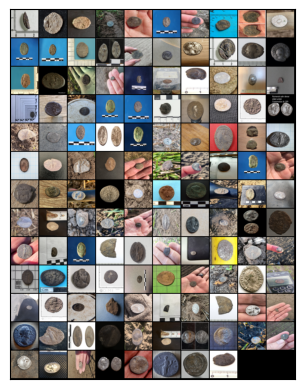

In [5]:
def show_image_grid(images: torch.Tensor, ncol: int): 
    image_grid = make_grid(
        images, 
        ncol
    ) # Make images into a grid 

    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last 
    image_grid = image_grid.cpu().numpy() 

    plt.imshow(image_grid)
    plt.xticks([]) # Empty x and y labels 
    plt.yticks([])
    plt.show() 


show_image_grid(
    images = images, 
    ncol = 10
)

In [6]:
n_channels = 3 # RGB

"""
def calc_output_size(input_size, kernel, padding, stride):
    return (input_size + 2 * padding - kernel // stride) + 1
"""

class D(nn.Module):
    def __init__(
        self,
        hyperparams: dict ,
        general_hyperparam: dict 
    ): 
        super(D, self).__init__()

        num_layers = hyperparams['num_layers']
        kernel_size = hyperparams['kernel_size']
        padding = hyperparams['padding']
        stride = hyperparams['stride']
        ndf = hyperparams['ndf']

        self.final_channel = 0  
        self.final_kernel = 0
        self.final_stride = 0
        self.final_padding = 0

        self.final_size = general_hyperparam['image_size']
        
        self.layers = nn.ModuleList() 

        # Dynamically add more layers 
        for i in range(num_layers):
            in_channels = n_channels if i == 0 else hyperparams['ndf'][i - 1]            
            out_channels = hyperparams['ndf'][i]
            kernel_size = hyperparams['kernel_size'][i]
            stride = hyperparams['stride'][i]
            padding = hyperparams['padding'][i]
            self.layers.append(
                nn.Conv2d(
                    in_channels = in_channels,
                    out_channels = out_channels,
                    kernel_size = kernel_size,
                    padding = padding,
                    stride = stride,
                    bias = False
                )
            )
            self.layers.append(
                nn.BatchNorm2d(
                    out_channels
                )
            )
            self.layers.append(
                nn.LeakyReLU(
                    inplace = True, 
                    negative_slope = 0.2 # TODO: MIGHT ADD TO HYPERPARAMETERS! 
                )
            )
            # For the next layer
            self.final_channel = out_channels
            self.final_kernel = kernel_size
            self.final_stride = stride
            self.final_padding = padding
            
            """
            # Calc the size of the output size 
            self.final_size = calc_output_size(
                input_size = self.final_size, 
                kernel = self.final_kernel,
                padding = self.final_padding, 
                stride = self.final_stride
            )
            """

        # Add final layer 
        self.layers.append(
            nn.Conv2d(
                in_channels = self.final_channel,
                out_channels = 1, # Final feature map
                kernel_size = self.final_kernel,
                padding = self.final_padding,
                stride = self.final_stride,
                bias = False
            )
        )

        self.layers.append(
            nn.Flatten() # Flatten image before FFN
        )
        
        self.layers.append(
            nn.Linear(
                in_features = self.final_size, 
                out_features = 1, 
                bias = False
            )
        )
        
        self.layers.append(
            nn.Sigmoid()
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            if isinstance(layer, nn.Flatten):
                self.final_size = x.size(1)
                # Update the current linear layer -> TODO: Does backpropagation work?
                self.layers[-2] = nn.Linear(in_features = self.final_size, out_features = 1, bias = False).to(device)
        return x



class G(nn.Module):
    def __init__(
        self,
        hyperparams: dict
    ): 
        super(G, self).__init__()

        latent_size = hyperparams['nz']
        num_feature_maps = hyperparams['ngf']
        
        self.layers = nn.ModuleList() 
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_size, num_feature_maps * 8, kernel_size = 4, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(num_feature_maps * 8),
            nn.ReLU(inplace = True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(num_feature_maps * 8, num_feature_maps * 4, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(inplace = True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(inplace = True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(inplace = True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(num_feature_maps, out_channels = n_channels, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )        

    def forward(self, x):
        x = self.main(x)
        return x 


In [14]:
trials = 25

num_epochs = 0
real_label = 1 
fake_label = 0 

D_losses = []
G_losses = []

img_list = []
iters = 0

best_score = float('-inf')
best_hyperparams = None
best_general_hyperparams = None

criterion = nn.BCELoss()

# Main folder to store the experiments in 
main_folder = "GAN_RANDOM_SEARCH"

hyperparameters_G = {
    'nz': [50, 100, 150, 200],  # Size of latent space vector 
    'lr': [round(i * 0.0001, 10) for i in range(1, 100)],  # Between 0.0001 and 0.0999
}

hyperparameters_D = {
    'ndf': list(range(32, 128)),  # Number of feature maps in discriminator
    'lr': [round(i * 0.0001, 15) for i in range(1, 100)],  
    'kernel_size': [1, 2, 3, 4],  
    'padding': [0, 1, 2],  
    'stride': [1, 2, 3], 
    'num_layers' : [1, 2, 3, 4, 5]
}

general_hyperparameters = {
    'batch_size': [32, 64, 128, 256],
    'num_epochs': [30, 50, 75, 100],
    'image_size': 128 # Image size NxN
}  

# Generator feature maps 
def generate_ngf() -> int:
    min_ngf = 32
    max_ngf = 128
    return random.randint(min_ngf, max_ngf) 

# Discriminator feature maps 
def generate_ndf_list(num_layers, initial_ndf, max_ndf):
    ndf_list = [initial_ndf]
    for _ in range(1, num_layers):
        new_ndf = random.randint(ndf_list[-1], max_ndf)
        ndf_list.append(new_ndf)
    return ndf_list

# TODO: Use pre-trained Inception_v4 model for feature extraction -> Save these?
def calculate_fid_fake_real():
    return None


for trial_num in range(trials):
    try:
        sampled_hyperparams_general = {
            'batch_size': random.choice(general_hyperparameters['batch_size']),
            'num_epochs': random.choice(general_hyperparameters['num_epochs']),
            'image_size': general_hyperparameters['image_size']
        }
    
        data_loader_rs = DataLoader(
            dataset, 
            sampled_hyperparams_general['batch_size'], 
            shuffle = True
        )
    
        # Discriminator only ---
        # Get number of feature maps
        num_layers = random.choice(hyperparameters_D['num_layers']) 
        initial_ndf = random.choice(hyperparameters_D['ndf'])  
        max_ndf = max(hyperparameters_D['ndf'])  
        ndf_list = generate_ndf_list(num_layers, initial_ndf, max_ndf)
        
        sampled_hyperparams_D = {
            'ndf': ndf_list, 
            'lr': random.choice(hyperparameters_D['lr']),    
            'kernel_size': [random.choice(hyperparameters_D['kernel_size']) for _ in range(num_layers)],  
            'padding': [random.choice(hyperparameters_D['padding']) for _ in range(num_layers)],         
            'stride': [random.choice(hyperparameters_D['stride']) for _ in range(num_layers)],          
            'num_layers': num_layers  
        }
        # ---
    
        sampled_hyperparams_G = {
            'nz': random.choice(hyperparameters_G['nz']),
            'ngf': generate_ngf(), 
            'lr': random.choice(hyperparameters_G['lr'])
        }
        
        num_epochs = sampled_hyperparams_general['num_epochs']
        batch_size = sampled_hyperparams_general['batch_size']
        
        fixed_noise = torch.randn(sampled_hyperparams_general['image_size'], sampled_hyperparams_G['nz'], 1, 1, device = device) 
        
        d_model = D(sampled_hyperparams_D, general_hyperparam = sampled_hyperparams_general) 
        g_model = G(hyperparams = sampled_hyperparams_G)
        d_model.to(device)
        g_model.to(device)
    
        optimizer_d = Adam(d_model.parameters(), lr = sampled_hyperparams_D['lr'])
        optimizer_g = Adam(g_model.parameters(), lr = sampled_hyperparams_G['lr'])
    
        for epoch in range(num_epochs): 
            for i, data in enumerate(data_loader_rs, 0): 
                # Train discriminator with real images
                d_model.zero_grad()
                real_device = data[0].to(device)
                b_size = real_device.size(0) # Real batch size 
                label = torch.full((b_size,), real_label, dtype = torch.float, device = device) # Fill the batch with real_labels i.e. 1
                label = label.view(-1) 
                # Forward 
                output = d_model(real_device).view(-1)
                
                errD_real = criterion(output, label)
                errD_real.backward()
                D_x = output.mean().item() # Mean loss from D model for each batch
    
                # Train discriminator with fake images 
                latent = torch.randn(b_size, sampled_hyperparams_G['nz'], 1, 1, device = device) # Create the latent vector with count(b_size) and dynamic size  
                fake = g_model(latent) # Feed latent vector sample to generator 
                label.fill_(fake_label) # Replace all labels with fake label
                output = d_model(fake.detach()).view(-1) # Feed and forget the fake image (detach) from the computational tree then Flatten output 
                errD_fake = criterion(output, label)
                errD_fake.backward() 
                D_G_z1 = output.mean().item() # The output loss from the discriminator based on fake images made by the generator (D_G_z1 -> D(G(z1))) - The mean across the batch
                errD = errD_real + errD_fake # Compute the total error for the discriminator over real and fake runs 
                optimizer_d.step()
    
                # Train the generator 
                g_model.zero_grad() 
                label.fill_(real_label) # fake labels are real for generator cost
                output = d_model(fake).view(-1) # Since we just updated D, perform another forward pass of all-fake batch through D (d_model)
                errG = criterion(output, label) # Calculate G's loss based on this output
                errG.backward()
                D_G_z2 = output.mean().item() # Same as (D_G_z1 -> D(G(z1))) - The output loss on fake images made by the generator. Training
                optimizer_g.step()
    
                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())
    
                # Output training stats
                if i % 50 == 0: # Run for every 50 iteration 
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                          % (epoch, num_epochs, i, len(data_loader),
                             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
                    with torch.no_grad():
                        fake = g_model(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))
        
                iters += 1
        
    # Errors should not affect the number of trials
    except Exception as e: 
        if trials == 0:
            trials = 0
        else: 
            trials -= 1 

    # END OF TRIAL ------------------------------------------------------------------------------------

    # Save sampled hyperparameters for this trial
    trial_hyperparams = {
        'general': sampled_hyperparams_general,
        'discriminator': sampled_hyperparams_D,
        'generator': sampled_hyperparams_G
    }
    
    # Trial folder
    trial_dir = os.path.join(main_folder, f"trial_{trial_num}")
    if not os.path.exists(trial_dir):
        os.makedirs(trial_dir)
    # Epoch folder
    epoch_dir = os.path.join(trial_dir, f"epoch_{epoch}")
    if not os.path.exists(epoch_dir):
        os.makedirs(epoch_dir)


    with open(os.path.join(epoch_dir, 'losses.txt'), "w") as f:
        f.write("Generator Losses:\n")
        f.write("\n".join(map(str, G_losses)))
        f.write("\n")
        f.write("\nDiscriminator Losses:\n")
        f.write("\n".join(map(str, D_losses)))
        f.write("\n")

    for i, img in enumerate(img_list):
        vutils.save_image(img, os.path.join(epoch_dir, f"epoch_{epoch}_image_{i}.png"))
    
    with open(os.path.join(epoch_dir, "hyperparameters.txt"), "w") as f:
        f.write("Hyperparameters:\n")
        for key, value in trial_hyperparams.items():
            f.write(f"{key}:\n")
            for param, val in value.items():
                f.write(f"{param}: {val}\n")

    # Plot and save the loss graphs
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label='Generator Loss')
    plt.plot(D_losses, label='Discriminator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    
    # Create a subfolder for loss graphs within the trial folder
    loss_graphs_dir = os.path.join(trial_dir, 'loss_graphs')
    os.makedirs(loss_graphs_dir, exist_ok=True)
    
    loss_graph_path = os.path.join(loss_graphs_dir, f'loss_graph_trial_{trial_num}.png')
    plt.savefig(loss_graph_path)
    plt.close()  # Close the plot to free memory


[0/1][0/14]	Loss_D: 1.3977	Loss_G: 0.8921	D(x): 0.4940	D(G(z)): 0.4988 / 0.4102
[0/1][50/14]	Loss_D: 1.8964	Loss_G: 0.7778	D(x): 0.3648	D(G(z)): 0.5526 / 0.4594
[0/1][0/14]	Loss_D: 1.3133	Loss_G: 1.0809	D(x): 0.5547	D(G(z)): 0.5130 / 0.3413
[0/1][0/14]	Loss_D: 1.4907	Loss_G: 0.7683	D(x): 0.4655	D(G(z)): 0.5145 / 0.4638
[0/1][50/14]	Loss_D: 1.3349	Loss_G: 0.7916	D(x): 0.4670	D(G(z)): 0.4299 / 0.4543
[0/1][0/14]	Loss_D: 1.3982	Loss_G: 0.9693	D(x): 0.4978	D(G(z)): 0.5000 / 0.3800
[0/1][50/14]	Loss_D: 1.3828	Loss_G: 0.6845	D(x): 0.5022	D(G(z)): 0.4991 / 0.5043
[0/1][0/14]	Loss_D: 1.3639	Loss_G: 0.5695	D(x): 0.5191	D(G(z)): 0.5025 / 0.5665
[0/1][0/14]	Loss_D: 1.3212	Loss_G: 0.6789	D(x): 0.4503	D(G(z)): 0.4044 / 0.5076
[0/1][0/14]	Loss_D: 1.5129	Loss_G: 1.4716	D(x): 0.4974	D(G(z)): 0.5542 / 0.2341
[0/1][0/14]	Loss_D: 1.3559	Loss_G: 2.6729	D(x): 0.5022	D(G(z)): 0.4837 / 0.0719
[0/1][50/14]	Loss_D: 1.3997	Loss_G: 0.6151	D(x): 0.4550	D(G(z)): 0.4555 / 0.5406
[0/1][0/14]	Loss_D: 1.2759	Loss_G: 0